In [167]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
from math import sqrt
from pathlib import Path

import pandas as pd
from loguru import logger
from scipy.stats import randint, uniform
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
pd.set_option("display.max_columns", None)

In [169]:
data_path = Path.cwd() / "data" / "r2.csv"
df = pd.read_csv(data_path)
y_col = "quality"
x_cols = [col for col in df.columns if col != y_col]

<Axes: title={'center': 'Quality Distribution'}, ylabel='Frequency'>

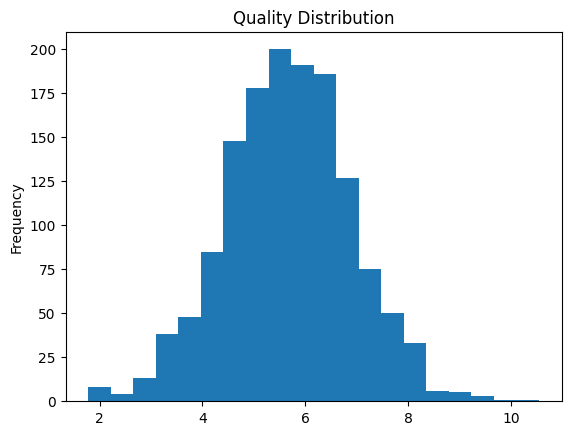

In [170]:
df[y_col].plot(kind="hist", bins=20, title="Quality Distribution")

In [171]:
df

,id,alcohol,chlorides,citric acid,density,feat01,feat02,feat03,feat04,feat05,feat06,feat07,feat08,feat09,feat10,fixed acidity,free sulfur dioxide,pH,quality,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,1,9.6,0.081,0.44,0.98920,0.777174,0.101811,0.615949,0.335220,0.072921,0.550654,0.321462,0.742844,0.120581,0.762964,9.7,23.0,3.49,4.248582,2.2,4.63,67.0,0.600
1,2,11.9,0.074,0.01,1.00371,0.682378,0.702689,0.595187,0.738317,0.079608,0.360016,0.668480,0.158404,0.377644,0.704609,7.9,33.0,3.44,6.365523,2.0,4.57,41.0,0.725
2,3,9.6,0.084,0.49,1.00870,0.477076,0.491814,0.123014,0.491648,0.112396,0.113222,0.413835,0.388120,0.513607,0.334223,9.2,23.0,3.38,5.094680,2.5,4.57,75.0,0.470
3,4,11.0,0.081,0.33,1.00490,0.745925,0.741657,0.769887,0.298042,0.167762,0.503632,0.839153,0.101733,0.157231,0.746054,7.1,24.0,3.44,5.903533,2.1,4.75,36.0,0.410
4,5,9.4,0.080,0.24,0.99620,0.729406,0.606721,0.425811,0.276605,0.944117,0.583265,0.542587,0.015201,0.796945,0.733268,7.8,6.0,3.31,6.267095,1.7,4.59,12.0,0.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1396,10.4,0.082,0.35,0.99798,0.192436,0.723544,0.199929,0.430688,0.967864,0.333939,0.500769,0.650995,0.409950,0.017794,10.7,26.0,3.24,6.535230,3.2,4.69,69.0,0.420
1396,1397,9.4,0.095,0.44,0.99708,0.704294,0.039272,0.161863,0.314071,0.774961,0.370215,0.480095,0.372677,0.517385,0.452004,9.5,11.0,3.31,4.568697,1.8,4.55,23.0,0.430
1397,1398,10.1,0.094,0.19,1.00787,0.882430,0.440148,0.837819,0.569797,0.357397,0.964399,0.281663,0.283731,0.553142,0.463633,9.0,32.0,3.25,7.242271,3.9,4.50,71.0,0.600
1398,1399,9.3,0.062,0.15,1.00550,0.545192,0.776621,0.897308,0.493320,0.982628,0.743984,0.453231,0.145450,0.573566,0.566089,6.3,8.0,3.45,5.288451,1.7,4.57,21.0,0.380


In [172]:
df.dtypes

id                        int64
alcohol                 float64
chlorides               float64
citric acid             float64
density                 float64
feat01                  float64
feat02                  float64
feat03                  float64
feat04                  float64
feat05                  float64
feat06                  float64
feat07                  float64
feat08                  float64
feat09                  float64
feat10                  float64
fixed acidity           float64
free sulfur dioxide     float64
pH                      float64
quality                 float64
residual sugar          float64
sulphates               float64
total sulfur dioxide    float64
volatile acidity        float64
dtype: object

In [173]:
df.isna().sum()

id                      0
alcohol                 0
chlorides               0
citric acid             0
density                 0
feat01                  0
feat02                  0
feat03                  0
feat04                  0
feat05                  0
feat06                  0
feat07                  0
feat08                  0
feat09                  0
feat10                  0
fixed acidity           0
free sulfur dioxide     0
pH                      0
quality                 0
residual sugar          0
sulphates               0
total sulfur dioxide    0
volatile acidity        0
dtype: int64

In [174]:
x, x_out_of_sample, y, y_out_of_sample = train_test_split(
    df[x_cols], df[y_col], test_size=0.2, random_state=42
)

In [175]:
@dataclass
class HyperoptInput:
    model: BaseEstimator
    hyperopt_space: dict[str, any] = field(default_factory=dict)


def get_pipeline_for_model(
    model: BaseEstimator, model_params: dict[str, any] | None = None
):
    return Pipeline(
        [
            ("scaler", RobustScaler()),
            (
                "feature_selection",
                SelectFromModel(XGBRegressor(), threshold="0.5*median"),
            ),
            ("model", model(**model_params if model_params else {})),
        ]
    )

In [176]:
base_hyperopt_inputs = [
    HyperoptInput(
        model=RandomForestRegressor,
        hyperopt_space={
            "model__n_jobs": [-1],
            "model__n_estimators": randint(100, 500),
            "model__max_depth": randint(3, 10),
            "model__min_samples_split": uniform(0.01, 0.1),
            "model__min_samples_leaf": uniform(0.01, 0.1),
        },
    ),
    HyperoptInput(
        model=XGBRegressor,
        hyperopt_space={
            "model__n_jobs": [-1],
            "model__n_estimators": randint(50, 500),
            "model__max_depth": randint(3, 10),
            "model__learning_rate": uniform(0.01, 0.3),
            "model__subsample": uniform(0.5, 0.5),
            "model__colsample_bytree": uniform(0.5, 0.5),
            "model__gamma": uniform(0, 5),
        },
    ),
    HyperoptInput(
        model=Ridge, hyperopt_space={"model__alpha": uniform(0.1, 100)}
    ),
    HyperoptInput(
        model=Lasso, hyperopt_space={"model__alpha": uniform(0.0001, 1.0)}
    ),
    HyperoptInput(
        model=SVR,
        hyperopt_space={
            "model__C": uniform(0.1, 10),
            "model__gamma": ["scale", "auto"],
            "model__epsilon": uniform(0.01, 0.1),
        },
    ),
    HyperoptInput(
        model=KNeighborsRegressor,
        hyperopt_space={
            "model__n_neighbors": randint(3, 30),
            "model__weights": ["uniform", "distance"],
            "model__p": [
                1,
                2,
            ],  # 1 is Manhattan distance, 2 is Euclidean distance
        },
    ),
]

In [177]:
@dataclass
class OneModelHyperoptResult:
    best_model: BaseEstimator
    best_score: float
    cv_results: pd.DataFrame

    def get_model_name(self) -> str:
        return self.best_model["model"].__class__.__name__


@dataclass
class HyperoptResults:
    results: list[OneModelHyperoptResult]

    def __post_init__(self):
        self._sort_by_best_score()

    def _sort_by_best_score(self, reversed: bool = True):
        self.results.sort(key=lambda x: x.best_score, reverse=reversed)

    def get_best_model(self):
        return self.results[0].best_model

    def get_best_score(self):
        return self.results[0].best_score

    def get_merged_df(self):
        results = pd.DataFrame()
        for result in self.results:
            results = pd.concat(
                [
                    results,
                    result.cv_results.assign(
                        model_name=result.get_model_name()
                    ),
                ],
                axis=0,
            )

        return results

    def get_all_dfs(self):
        return [
            (result.get_model_name(), result.cv_results)
            for result in self.results
        ]

    def get_all_scores(self):
        return [
            (result.get_model_name(), result.best_score)
            for result in self.results
        ]

    def get_all_models(self):
        return [
            (result.get_model_name(), result.best_model)
            for result in self.results
        ]


def run_hyperopt_one_model(
    x: pd.DataFrame,
    y: pd.Series,
    model_input: HyperoptInput,
    n_iter: int = 10,
    cv: int = 5,
    random_state: int = 42,
):
    pipeline = get_pipeline_for_model(model_input.model)
    search = RandomizedSearchCV(
        pipeline,
        model_input.hyperopt_space,
        n_iter=n_iter,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        cv=cv,
        random_state=random_state,
    )
    search.fit(x, y)
    return OneModelHyperoptResult(
        best_model=search.best_estimator_,
        best_score=search.best_score_,
        cv_results=pd.DataFrame(search.cv_results_),
    )

In [178]:
def run_hyperopt(
    hyperopt_inputs=base_hyperopt_inputs,
    n_iter: int = 10,
    cv: int = 5,
    random_state: int = 42,
) -> HyperoptResults:
    results = []
    for model_input in hyperopt_inputs:
        logger.info(f"Running hyperopt for {model_input.model.__name__}")
        result = run_hyperopt_one_model(
            x=x,
            y=y,
            model_input=model_input,
            n_iter=n_iter,
            cv=cv,
            random_state=random_state,
        )
        results.append(result)
        logger.info(f"Best score: {result.best_score}")
    return HyperoptResults(results=results)

In [179]:
results = run_hyperopt()

2023-12-05 23:30:40.306 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for RandomForestRegressor
2023-12-05 23:30:53.592 | INFO     | __main__:run_hyperopt:19 - Best score: -1.138144746017916
2023-12-05 23:30:53.593 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for XGBRegressor
2023-12-05 23:30:57.435 | INFO     | __main__:run_hyperopt:19 - Best score: -1.0927928130081312
2023-12-05 23:30:57.435 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for Ridge
2023-12-05 23:30:59.579 | INFO     | __main__:run_hyperopt:19 - Best score: -1.1159509414165998
2023-12-05 23:30:59.580 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for Lasso
2023-12-05 23:31:01.992 | INFO     | __main__:run_hyperopt:19 - Best score: -1.1449999767811474
2023-12-05 23:31:01.993 | INFO     | __main__:run_hyperopt:9 - Running hyperopt for SVR
2023-12-05 23:31:04.693 | INFO     | __main__:run_hyperopt:19 - Best score: -1.1433332634098856
2023-12-05 23:31:04.694 | INFO     | __main__:run_

In [180]:
results.get_merged_df()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__n_jobs,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model_name,param_model__alpha,param_model__min_samples_leaf,param_model__min_samples_split,param_model__C,param_model__epsilon,param_model__n_neighbors,param_model__p,param_model__weights
0,0.288043,0.067012,0.001760,0.000015,0.68727,4.753572,0.229598,7,70,-1,0.578009,{'model__colsample_bytree': 0.6872700594236812...,-1.257862,-1.280856,-1.185401,-1.157436,-1.343660,-1.245043,0.066939,8,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.287675,0.025879,0.001795,0.000036,0.577997,0.290418,0.269853,6,409,-1,0.854036,{'model__colsample_bytree': 0.5779972601681014...,-1.385186,-1.212206,-1.325609,-1.238253,-1.444752,-1.321201,0.087337,10,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.264402,0.020904,0.002543,0.001060,0.510292,4.849549,0.259733,8,435,-1,0.590912,{'model__colsample_bytree': 0.5102922471479012...,-1.300253,-1.217897,-1.158358,-1.224047,-1.458655,-1.271842,0.103710,9,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.308679,0.018515,0.002917,0.002063,0.591702,1.521211,0.167427,6,394,-1,0.645615,{'model__colsample_bytree': 0.5917022549267169...,-1.338786,-1.200178,-1.109741,-1.197086,-1.359076,-1.240974,0.094157,7,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.424455,0.014249,0.004666,0.003937,0.805926,0.697469,0.097643,9,239,-1,0.545303,{'model__colsample_bytree': 0.8059264473611898...,-1.277747,-1.125357,-1.090480,-1.058585,-1.340641,-1.178562,0.110536,4,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.256419,0.034832,0.002322,0.001335,0.809193,1.91231,0.304969,3,180,-1,0.92997,{'model__colsample_bytree': 0.8091930046665436...,-1.256604,-1.135068,-1.215714,-1.110507,-1.467560,-1.237091,0.126796,6,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.389141,0.033987,0.001999,0.000017,0.840154,2.252496,0.013979,3,365,-1,0.781644,{'model__colsample_bytree': 0.8401537692938899...,-1.127510,-1.074650,-1.014972,-1.018470,-1.228362,-1.092793,0.079364,1,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.467579,0.043698,0.002227,0.000034,0.692708,0.079831,0.079268,6,416,-1,0.841632,"{'model__colsample_bytree': 0.692708251269958,...",-1.295919,-1.163151,-1.134367,-1.113825,-1.360107,-1.213474,0.096973,5,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.306273,0.017250,0.001898,0.000023,0.804998,4.165975,0.062009,3,469,-1,0.591118,{'model__colsample_bytree': 0.8049983288913105...,-1.173273,-1.074480,-1.037513,-1.011863,-1.242808,-1.107987,0.086912,2,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.327313,0.028282,0.002104,0.000031,0.877681,2.125779,0.072382,6,359,-1,0.515657,{'model__colsample_bytree': 0.8776807051588262...,-1.236797,-1.142429,-1.071126,-1.098471,-1.294353,-1.168635,0.084343,3,XGBRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
results.get_all_scores()

[('XGBRegressor', -1.0927928130081312),
 ('Ridge', -1.1159509414165998),
 ('RandomForestRegressor', -1.138144746017916),
 ('SVR', -1.1433332634098856),
 ('Lasso', -1.1449999767811474),
 ('KNeighborsRegressor', -1.229779126770083)]

In [182]:
best_model = results.get_best_model()
best_model

Pipeline(steps=[('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None,
                                                        grow_policy=None,
                                                        importanc...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.013979488347959958, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=365, n_jobs=-1,
                              num_parallel_tree=None, random_state=None, ...))])

In [183]:
@dataclass
class RegressionScores:
    mean_squared_error: float
    mean_absolute_error: float
    root_mean_squared_error: float


def calculate_regression_scores(
    model: BaseEstimator, X_test: pd.DataFrame, y_test: pd.Series
) -> RegressionScores:
    y_pred = model.predict(X_test)
    y_pred = [
        max(0, min(pred, 10)) for pred in y_pred
    ]  # ensure that we don't have negative or >10 predictions
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mse)

    return RegressionScores(
        mean_squared_error=mse,
        mean_absolute_error=mae,
        root_mean_squared_error=rmse,
    )

In [184]:
best_model_scores = calculate_regression_scores(
    best_model, x_out_of_sample, y_out_of_sample
)
best_model_scores

RegressionScores(mean_squared_error=1.36515466797506, mean_absolute_error=0.8952051777187162, root_mean_squared_error=1.1683983344626352)